# Implementing Logistic Regression

### Abstract

In this blog post, I explore the strength and limite of gradient descent algorithm on logistic regression method on empirical risk minimization problems under different data scenarios. First, I implement gradient descent for logistic regression in an object-oriented paradigm. Next, I introduce a momentum term to the gradient descent function and see how it could make the algorithm converge faster compared with the classical gradient descent without the momentum term. Last, I will experiment the model on data with higher dimensions and demonstrate its potential for overfitting. The object-oriented paradigm of the logistic regression could be seen here [logistic.py](logistic.py). 

In [2]:
import torch
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer

### Part A: Implementing Logistic Regression

### Implement `LinearModel` and `LogisticRegression()`

In my object-oriented paradigm of the logistic regression, we will create a new class called `LogisticRegression` which inherits from `LinearModel`. This class should have two methods: 

- `LogisticRegression.loss(X, y)` computes the empirical risk $L(\mathbf{w})$ using the logistic loss function 
$$
\begin{aligned}
    L(\mathbf{w}) = \frac{1}{n} \sum_{i = 1}^n \left[-y_i \log \sigma(s_i) - (1-y_i)\log (1-\sigma(s_i))\right]
\end{aligned}
$$
The weight vector $\mathbf{w}$ used for this calculation should be stored as an instance variable of the class. 
- `LogisticRegression.grad(X, y)` should compute the *gradient* of the empirical risk $L(\mathbf{w})$. I use [the formula](https://www.philchodrow.prof/ml-notes/chapters/23-gradient-descent.html#eq-logistic-gradient) provided by Professor Chdrow for the gradient supplied in the lecture notes on gradient descent. 

### Implement `GradientDescentOptimizer.step()`

Next, we will implement a `GradientDescentOptimizer` class. For this project, we are going to implement *gradient descent with momentum*, also known as Spicy Gradient Descent. Let $\mathbf{w}_k$ be the estimate of the weight vector at algorithmic step $k$ [This description of gradient descent with momentum is based on @hardtPatternsPredictionsActions2022.]{.aside}
$$
\begin{aligned}
    \mathbf{w}_{k+1} \gets \mathbf{w}_k - \alpha \nabla L(\mathbf{w}_k) + \beta(\mathbf{w}_k - \mathbf{w}_{k-1}) 
\end{aligned}
$${#eq-gradient-momentum}

Here, $\alpha$ and $\beta$ are *two* learning rate parameters. When $\beta = 0$ we have "regular" gradient descent. In practice, a choice of $\beta \approx 0.9$ or so is common.

### Experiments

First, we want to generate data for the classification problem. Here is a function that would help us to generate data of two classes. We can determine the noise of the data, which represents to what extent these two classes of data are mixed together. Here, I am creating a two dimensional experimental data with noise equals to 0.3. 

In [3]:
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y
torch.manual_seed(123989)
X, y = classification_data(noise = 0.3)

Here is how the data looks like when displayed on a coordinate system. 

Text(0.5, 1.0, 'Distribution of Experimental Data')

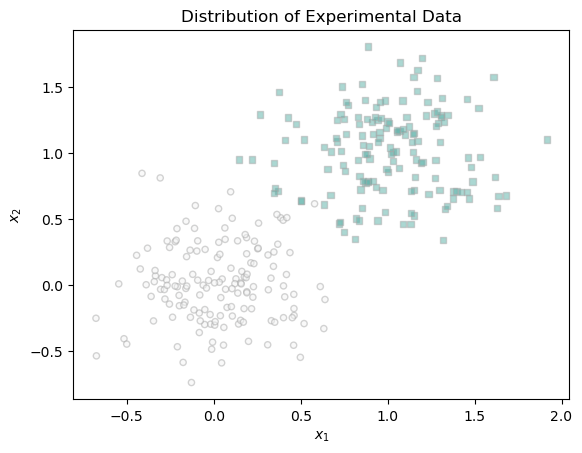

In [4]:
from matplotlib import pyplot as plt
def plot_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1)
plot_data(X, y, ax)
ax.set_title("Distribution of Experimental Data")

Now, we want to do the experiment and train our model. First, we initiate the Logistic Regression model and the optimization fnction and implement a gradient descent loop. We want to keep track about the loss value to see how the training process gradually takes us to a decision boundary that best classifies the two groups of data. 

##### Experiment 1: Vanilla gradient descent
In the first experiment, we let $\beta = 0$ so there is no momentum term in the step function (we call this the "Vanilla" case). Set the learning rate to be $\alpha = 0.01$. 

In [5]:
#initiate logistic regression and optimization function
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

# for keeping track of loss values
loss_vec = []

alpha = 0.01

for _ in range(1000):
    # add other stuff to e.g. keep track of the loss over time.
    
    opt.step(X, y, alpha, beta = 0)

    loss = LR.loss(X, y) 
    loss_vec.append(loss)

Here is how the loss fuction has evolved after 1000 iterations. 

Text(0.5, 1.0, "Evolution of Loss Function ('Vanilla' Case)")

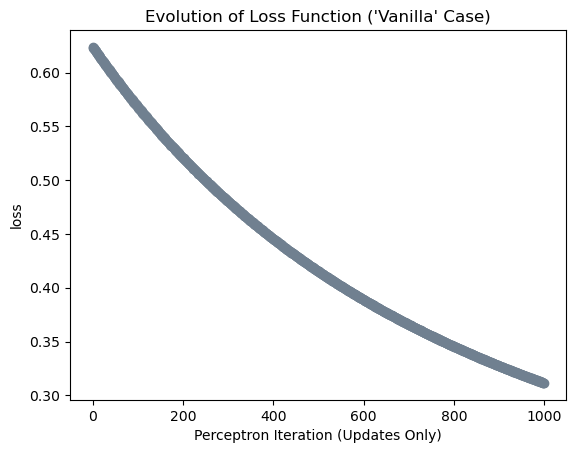

In [6]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")
plt.title("Evolution of Loss Function ('Vanilla' Case)")

Here is how the decision boundary looks like after 1000 iterations of training. 

Text(0.5, 1.0, 'Decision Boundary')

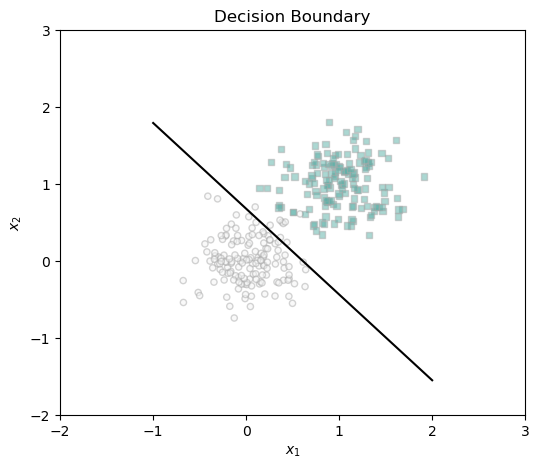

In [7]:
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

fig, ax = plt.subplots(1, 1, figsize = (6, 5))
ax.set(xlim = (-2, 3), ylim = (-2, 3))
plot_data(X, y, ax)
draw_line(LR.w, -1, 2, ax, color = "black")
ax.set_title("Decision Boundary")

##### Experiment 2: Benefits of momentum
Now, we want to increase the paramter $\beta$ to 0.9 to activate the momentum term. This modification will theoretically let the weight vector $\mathbf{w}$ to converge faster to the best decision boundary. In other words, compared with the "Vanilla" gradient descent, the momentum descent will take fewer steps to arrive at the same loss function. 

Similar to the process above, we initiate the logistic regression model and optimizer, as well as creating a loss vector that will keep track with how the weight vector has evolved through iteratios. 

In [8]:
# for keeping track of loss values
loss_vec_mom = []

# set seed
#torch.manual_seed(1234)

# initialize logistic regression model and optimizer
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

for _ in range(1000):
    opt.step(X, y, alpha, beta = 0.9)
    
    loss_1= LR.loss(X, y) 
    loss_vec_mom.append(loss_1)

Here is how the loss function's evolution in "Vanilla" and "Momentum" cases compare with each other. 

Text(0.5, 1.0, 'Evolution of Loss Function - Comparison')

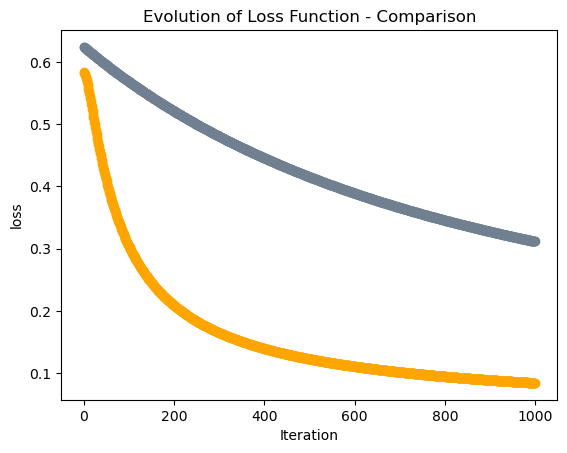

In [9]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")

plt.plot(loss_vec_mom, color = "orange")
plt.scatter(torch.arange(len(loss_vec_mom)), loss_vec_mom, color = "orange")

labs = plt.gca().set(xlabel = "Iteration", ylabel = "loss")
plt.title("Evolution of Loss Function - Comparison")

It is obvious tha the loss function with momentum term decreases much faster than that without the momentum term. The reult resonates with our hypothesis before that the momentum gradient descent will take fewer steps to arrive at the same loss function comparing with the "Vanilla" gradient descent. 


##### Experiemnt 3: Overfitting
To show the potential danger of overfitting using logistic regression gradient descent on modeling, we generate two data sets that have higher dimension than the number of points `p_dim > n_points`. In my case, my two data sets both have 20 points, and each data points has a dimension of 30. I call on data set to be my training data `X_train` and `y_train`, upon which I will train my model. I expect the logistic regression gradient descent model will give me a 100% training accuracy. The other data set will be my testing data `X_test` and `y_test`, upon which I will I apply the 100% accurate model on my trainig model to it. 

As usual, we generate data, train the model by performing the gradient descent for 100 iterations, and record the loss function vector. 

In [10]:
torch.manual_seed(8999)

n_points = 20
noise = 0.6
p_dims = 30

X_train, y_train = classification_data(n_points, noise, p_dims)
X_test, y_test = classification_data(n_points, noise, p_dims)

# initialize logistic regression model and optimizer
LR_1 = LogisticRegression() 
opt = GradientDescentOptimizer(LR_1)

loss_vec_ovft = []

for _ in range(100):

    opt.step(X_train, y_train, alpha = 0.4, beta = 0.9)
    
    loss_1 = LR_1.loss(X_train, y_train).item()
    loss_vec_ovft.append(loss_1)

loss_vec_ovft

[nan,
 0.4822104871273041,
 0.36730942130088806,
 0.25451797246932983,
 0.15861986577510834,
 0.08826088160276413,
 0.04635719582438469,
 0.025417977944016457,
 0.015304912813007832,
 0.010332601144909859,
 0.008140804246068,
 0.007808966096490622,
 0.008864100091159344,
 0.010700022801756859,
 0.012347049079835415,
 0.012820164673030376,
 0.011777261272072792,
 0.009697656147181988,
 0.007375537417829037,
 0.005366646684706211,
 0.0038542163092643023,
 0.002794929314404726,
 0.002075385767966509,
 0.0015891505172476172,
 0.0012573981657624245,
 0.0010270343627780676,
 0.0008635885897092521,
 0.000744955032132566,
 0.0006568970857188106,
 0.000590068637393415,
 0.0005383479292504489,
 0.0004975631018169224,
 0.0004648646281566471,
 0.00043824725435115397,
 0.0004162801487836987,
 0.0003979210159741342,
 0.0003824058221653104,
 0.00036920601269230247,
 0.0003578083706088364,
 0.0003479263687040657,
 0.0003393034276086837,
 0.0003316978400107473,
 0.0003249812580179423,
 0.00031898668385

Text(0.5, 1.0, 'Evolution of Loss Function - Overfit Test Data')

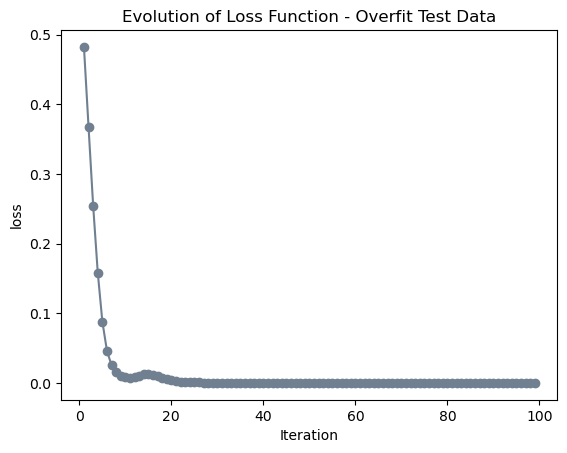

In [11]:
plt.plot(loss_vec_ovft, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec_ovft)), loss_vec_ovft, color = "slategrey")
labs = plt.gca().set(xlabel = "Iteration", ylabel = "loss")
plt.title("Evolution of Loss Function - Overfit Test Data")

Let us see how is the accuracy on the training data is alike. 

In [12]:
preds = LR_1.predict(X_train)
correct_preds = (preds == y_train).sum()
train_acc = correct_preds / len(y_train)
train_acc.item()

1.0

It is 100% correct! How about we apply this to the testing data?

In [13]:
test_pred = LR_1.predict(X_test)
correct_test_preds = (test_pred == y_test).sum()
test_acc = (correct_test_preds / len(y_test))
test_acc.item()

0.8999999761581421

The accuracy decreases to 90%. The difference of accuracy demonstrates that the model trained using the logistic regression gradient descent could be over-trained and thus overfits the training data. 

### Conclusion

Through this blog post, I understood the underlying mechanisms and equations that are used for the logistic regression gradient descent. Different from the perceptron algorithm that adjusts the boundary layer using one or some points in the data, the logistic regression gradient descent adjusts the decision boundary using all data points of the data set. The convexity property of the logistic function is applied so that we know the gradient descent will eventually lead us to a minimum loss value, which means the algorithm with converges to the best decision boundary. We further applied "Spicy Gradient Descent", which adds a momentum term to the logistic regression function and helps us to get to the minimum loss faster. We also showed the danger of overfitting for logistic regression gradient descent: though we can train the model to find the best separation boundary for the training data, the quality of classification may not apply to the testing data, especially when the dimension of the data is higher. 